In [1]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [2]:
df = PandasTools.LoadSDF(r'D:\AI-Drug\Rate Prediction\mol2vec_document\mol2vec-master\examples\data\ames.sdf')

In [3]:
df.head()

,class,ID,ROMol
0,0,2475-33-4,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...
1,0,105149-00-6,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...
2,0,108-78-1,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...
3,1,2425-85-6,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...
4,0,67019-24-3,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...


In [4]:
len(df)

6506

In [4]:
model = word2vec.Word2Vec.load(r'D:\AI-Drug\Rate Prediction\mol2vec_document\mol2vec-master\examples\models\model_300dim.pkl')

In [5]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

In [6]:
df.head()

,class,ID,ROMol,sentence,mol2vec
0,0,2475-33-4,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...,"(864942730, 10565946, 3217380708, 3631761933, ...","(300,) dimensional vector"
1,0,105149-00-6,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...,"(2246728737, 3545365497, 2246699815, 266499585...","(300,) dimensional vector"
2,0,108-78-1,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...,"(847957139, 1083852209, 3217380708, 472281497,...","(300,) dimensional vector"
3,1,2425-85-6,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...,"(2246728737, 422715066, 3217380708, 3207567135...","(300,) dimensional vector"
4,0,67019-24-3,<rdkit.Chem.rdchem.Mol object at 0x000001E6780...,"(2246728737, 3537119515, 2245273601, 242354360...","(300,) dimensional vector"


In [9]:
df['mol2vec'][0].vec

array([ 5.4569573e+00, -4.5774226e+00, -1.2368451e+01,  1.6083830e+01,
       -3.4344354e+00,  7.8346562e+00, -1.9782095e+01,  2.4867506e+00,
        1.1419450e+01,  1.1417440e+01, -9.0617828e+00, -8.7552130e-01,
       -1.7590702e+01, -8.9261091e-01, -1.0669560e+01,  3.1299016e+00,
        7.4900413e+00, -8.2281895e+00, -7.2957749e+00,  1.4930939e+01,
        3.1109862e+00,  1.6593018e+01,  3.1732065e+01,  2.3081747e+01,
       -1.8497038e+01, -5.9619637e+00, -2.1787539e+00, -2.1790316e+01,
        6.0134184e-01,  2.8226905e+00,  2.8222307e+01, -1.2402632e+01,
       -6.3831921e+00, -1.6101770e+01,  1.4035272e+01,  1.1607525e+01,
        1.8667759e+00,  3.3354443e-01,  1.5872900e+01,  7.4314289e+00,
       -1.5619795e+00, -3.7712212e+00, -1.0340467e+01,  2.6325300e+00,
       -2.4675711e+01,  9.0269032e+00, -5.5357995e+00,  1.0565917e+01,
       -1.0436458e+01, -1.0878086e-02,  1.2207945e+01, -1.3658039e+01,
        2.4342692e-01, -2.0825615e+01, -9.5794716e+00, -5.7432823e+00,
      

In [7]:
X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['class'].astype(int))

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [9]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [10]:
y_values = []
predictions = []
probas = []
for train, test in kf.split(X, y):
    clf = RandomForestClassifier(n_estimators=500, random_state=0)
    clf.fit(X[train], y[train])
    predictions.append(clf.predict(X[test]))
    probas.append(clf.predict_proba(X[test]).T[1]) # Probabilities for class 1
    y_values.append(y[test])
    del clf

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [12]:
aucs = [roc_auc_score(y, proba) for y, proba in zip(y_values, probas)]

In [13]:
np.mean(aucs), np.std(aucs)

(0.8686917091204087, 0.004411664917973581)

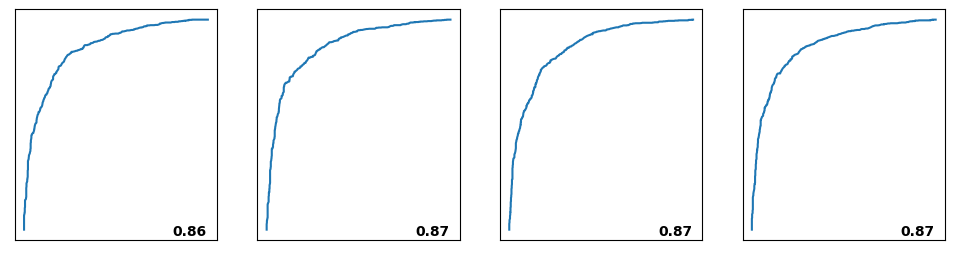

In [14]:
f, ((p1, p2, p3, p4)) = plt.subplots(1,4, squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(12,3))

for y,proba,ax in zip(y_values, probas, (p1,p2,p3,p4)):
    tpr, fpr, _ = roc_curve(y, proba)
    auc = roc_auc_score(y, proba)
    ax.plot(tpr, fpr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%0.2f" % auc,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)
plt.show()